# Interactive Linear Regression via Gradient Descent
## By Hanan Shteingart 
In this notebook you will learn how to solve a linear regression problem (polynomial fit) using a gradient descent algorithm. 

The concepts you will learn are the basics introduction to **Deep Learning**.

You will learn how to:
1. Generate a true-underlying random model
2. Sample data from the model with noise
3. Define a model for the observed sampled data
4. Fit the model to the data
5. Interactively experiment with different settings (e.g. learning rate) and learn these lessons
    a. The effect of learning rate (too small too slow, too large -> overflow)
    b. The effect of number of iteration (too little->no convergance, too many->slow and redundant)
    c. Bias-variance tradeoff: if the model is too simple or too complex it hurts dev set loss
    d. The effect of noise: more samples are needed for convergance 
    e. Learning curve: the effect of increasing the number of training data (in biased regim it is not helpful).



In [130]:
# First, Import!
import numpy as np # for computations
%matplotlib inline
import matplotlib.pyplot as plt # for plotting
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider # for interactivity

# Polynom Refresher
Polynom is a (weighted) sum over powers of a variable: e.g. $y=3.14x^3 + 4.5x^2 -1.2x^1 + 1$

The general expression is $y=\sum_{k=0}^{k=d}{w[k]x^k}$ where $d$ is the degree of the polynom and $w$ are the polynom coefficients. 

In the example above the degree was 3 and the coefficients where [1, -1.2, 4.5, 3.14], respectively (notice the number of coefficients is the degree + 1).

**Theorem**: If p points are given in 2D space $(x_i, y_i)$ $i\in[1,n]$, the points, can be perfectly be fitted using a polynom of degree p-1 or more.

**Handwave Proof**: there are p arbitrary equations (one for each point), if there are at least p variables a solution is plausible always.

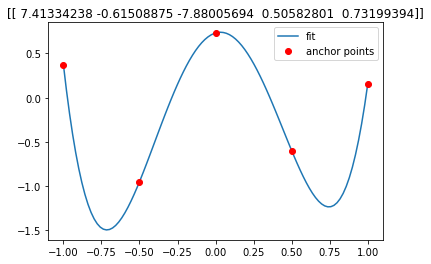

In [131]:
# Generate a Polynom by sampling p points in a (-1,1)-(1,1) rectangular and fit a polynom through it.
p_true = 5
def sample_polynom(p=p_true, seed=42):
    "create p standard normal random points in 2D and fit a polynom through them"
    np.random.seed(seed)
    x0 = np.linspace(-1,1,p)
    y0 = np.random.uniform(0,1,p)
    alternating = np.power(-1, np.arange(len(y0))) * np.power(-1, np.random.randint(low=0, high=2))
    y0 = y0 * alternating
    w_true = np.polyfit(x=x0, y=y0, deg=p-1).reshape(-1,1)
    n_plot = 100
    x = np.linspace(-1,1, n_plot).reshape(-1,1)
    y = np.polyval(p=w_true, x=x).reshape(-1,1)
    return w_true, x0, y0, x, y

w_true, x0, y0, x, y= sample_polynom()
plt.plot(x, y, label='fit')
plt.plot(x0,y0,'ro', label='anchor points')
plt.legend(loc='best')
plt.title(w_true.T)

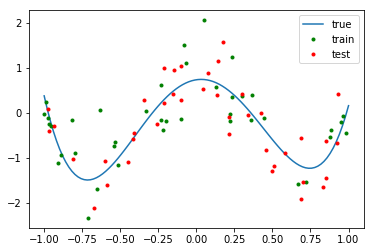

In [132]:
# generate a sample using the true model + noise
def generate_sample(w_true, n=40, noise=0.5):
    x_train = np.random.uniform(-1, 1, size=n).reshape(-1,1)
    x_test = np.random.uniform(-1, 1, size=n).reshape(-1,1)
    y_train = np.polyval(p=w_true, x=x_train).reshape(-1,1) + noise*np.random.randn(*x_train.shape)
    y_test = np.polyval(p=w_true, x=x_test).reshape(-1,1) + noise*np.random.randn(*x_test.shape)
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = generate_sample(w_true=w_true)
plt.plot(x, y,label='true')
plt.plot(x_train,y_train,'g.',label='train')
plt.plot(x_test,y_test,'r.',label='test')
plt.legend()

# Define Model & Loss
Define a model: $ \hat{y} = f(x;\Theta) $ where $\Theta$ are the model parameters.

For example, $\Theta=p$ is the number of polynom coefficients (degree+1), in that case $f(x,p)=\sum{w[k] x^k}$

Define a loss function, e.g. square loss: $L(\hat{y},y)=\sum_i{(y_i-\hat{y_i})^2}$

In [133]:
def calc_loss(y, y_hat):
    y_err = y_hat - y
    m = len(y_err)
    loss = 1/m * np.square(y_err).sum()
    return loss
def calc_powers(x, p):
    powers = np.arange(p).reshape(1,-1) # vector 1 x p
    X = np.power(x, powers) # matrix of n X p (using numpy broadcasting)
    return X
def calc_y_hat(X, w):
    y_hat = np.dot(X, w)
    return y_hat
assert calc_loss(np.array([1,2,5]),np.array([1,3,4]))==2/3
assert np.all(calc_powers(np.array([1,2,3]).reshape(-1,1),p=3)==np.array([[1,1,1],[1,2,4],[1,3,9]]))


# Derivate Loss by Parameters
Derivate the loss in respect to the model parameters:
$\partial_{w_k}L(\hat{y},y)=\sum_i{(y_i-\hat{y_i})^2}=-2\sum(y_i-\hat{y_i})x^k$

In [134]:
def calc_grad(X, y, y_hat):
    """
    X - (n,p)
    y - (n,1)
    y_hat - (n,1)
    result: grad (p,1)
    """
    y_err = y_hat - y
    m = len(y_err)
    grad = 1/m * 2*np.dot(X.T, y_err)
    return grad
def init_w(p):
    w = np.zeros([p, 1]) # vector 1xp
    return w

# Check Gradient

In [135]:
def gradient_check(x,y,p=3, w=None, eps=1e-3):
    X = calc_powers(x, p)
    if w is None:
        w = init_w(p)
    y_hat = calc_y_hat(X, w)
    loss = calc_loss(y, y_hat)
    grad_analytical = calc_grad(X,y,y_hat)
    grad_numerical = np.zeros_like(w)
    for i in range(len(w)):
        w_plus = w.copy()
        w_plus[i] = w[i] + eps
        w_minus = w.copy()
        w_minus[i] = w[i] - eps
        y_plus = calc_y_hat(X, w_plus)
        y_minus = calc_y_hat(X, w_minus)
        loss_plus = calc_loss(y, y_plus)
        loss_minus = calc_loss(y, y_minus)
        grad_numerical[i] = (loss_plus-loss_minus)/(2*eps)
    np.testing.assert_almost_equal(grad_analytical, grad_numerical,decimal=3)
    return grad_analytical, grad_numerical

n_trials = 100
for trial in range(n_trials):
    grad_analytical, grad_numerical = gradient_check(x_train,y_train, w=10*np.random.randn(3).reshape(-1,1))

# Learning by Gradient Decent
Update the weights according to the minus gradient

In [136]:
def train(x, y, p, x_dev=None, y_dev=None,
          learning_rate=0.001, n_epochs=1000, verbose=False, normalize=True):
    x_mat = calc_powers(x, p)
    if normalize:
        std = x_mat.std()
        #mean = x_mat.mean()
        if p>1: # otherwise std=0
            x_mat = x_mat / std
    w = init_w(p)
    loss_list = []
    if x_dev is not None:
        x_mat_dev = calc_powers(x_dev, p)/std
        dev_loss_list = []
    else:
        dev_loss_list = None
    for epoch in range(n_epochs):
        y_hat = calc_y_hat(x_mat, w)
        loss = calc_loss(y, y_hat)
        loss_list.append(loss)
        if x_dev is not None:
            y_hat_dev = calc_y_hat(x_mat_dev, w)
            loss_dev = calc_loss(y_dev, y_hat_dev)
            dev_loss_list.append(loss_dev)
        if verbose:
            print(epoch, ":", loss)
        grad = calc_grad(x_mat, y, y_hat)
        w= w-learning_rate * grad
    if normalize:
        w = w/std
    if x_dev is None:
        return w, loss_list
    else:
        return w, loss_list, dev_loss_list

# Experiment

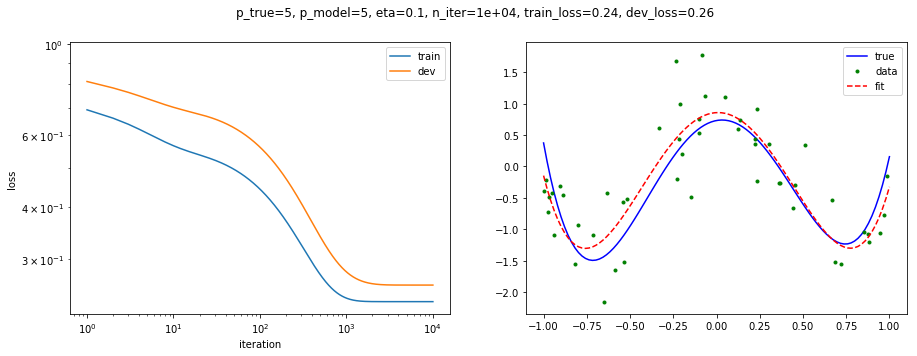

In [137]:
def experiment(p_true=5,seed=42, p_model=5, 
               n_train=50, noise=0.5, 
               log10_learning_rate=-1, n_epochs=int(1e4)):
    w_true, x0, y0,x,y = sample_polynom(p=p_true, seed=seed)
    x_train, y_train, x_test, y_test = generate_sample(w_true=w_true, n=n_train, noise=noise)
    learning_rate=np.power(10.0, log10_learning_rate)
    w_est, loss_trace, dev_loss_trace = train(x=x_train,y=y_train,
                              p=p_model, 
                              learning_rate =learning_rate, 
                              n_epochs=n_epochs, verbose=False, x_dev=x_test, y_dev=y_test)
    plt.figure(1,figsize=(15,5))
    plt.subplot(1,2,1)
    plt.loglog(loss_trace, label='train')
    plt.loglog(dev_loss_trace, label='dev')
    #plt.ylim(10**-2, 10**1)
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.subplot(1,2,2)
    plt.plot(x, y,'b-', label='true')
    plt.plot(x_train, y_train,'g.',label='data')
    plt.plot(x, calc_y_hat(X=calc_powers(x, p=p_model), w=w_est),'r--',label='fit')
    plt.legend()
    plt.suptitle('p_true=%d, p_model=%d, eta=%3.2g, n_iter=%3.2g, train_loss=%3.2f, dev_loss=%3.2f'%
                 (p_true, p_model, learning_rate, n_epochs, loss_trace[-1], dev_loss_trace[-1]))
    plt.show()
experiment()

In [138]:
p_true_widget = IntSlider(min=2, max=10,value=p_true)
p_model_widget = IntSlider(min=2, max=10,value=p_true)
seed_widget = IntSlider(min=1, max=42,value=42)
n_train_widget = IntSlider(min=10, max=100,value=20)
noise_widget = FloatSlider(min=0, max=10, step=0.1, value=0.5)
log10_learning_rate_widget = FloatSlider(min=-4, max=0, value=-1, step=0.1)


n_epochs_widget = IntSlider(min=100, max=100000, step=100, value=1000)

interactive_plot = interact(experiment, 
                            p_true=p_true_widget,
                            seed=seed_widget,
                            n_train=n_train_widget,
                            noise=noise_widget,
                            p_model=p_model_widget, 
                            log10_learning_rate=log10_learning_rate_widget, 
                            n_epochs=n_epochs_widget, 
                            continuous_update=False)
interactive_plot 

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.experiment>